In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 1. 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로더 구성

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNUSED>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 


In [4]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수 
# 단, 모든 문장은 <BOS>로 시작. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


In [6]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
import numpy as np
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 4. 모델 구성 및 validation set 구성

### 1) LSTM 모델

In [8]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 16  # 워드 벡터의 차원 수

model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1.add(tf.keras.layers.LSTM(8))
model_1.add(tf.keras.layers.Dense(8, activation='relu'))
model_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 대략 1/3로 나눠지기 위해  train set(101182), val set(45000)으로 정하였다
X_val = X_train[:45000]   
y_val = y_train[:45000]

partial_X_train = X_train[45000:]  
partial_y_train = y_train[45000:]

print(X_val.shape)
print(y_val.shape)
print(partial_X_train.shape)
print(partial_y_train.shape)

(45000, 41)
(45000,)
(101182, 41)
(101182,)


In [10]:
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10 

history = model_1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
198/198 [==============================] - 5s 9ms/step - loss: 0.5401 - accuracy: 0.7277 - val_loss: 0.3765 - val_accuracy: 0.8405
Epoch 2/10
198/198 [==============================] - 1s 6ms/step - loss: 0.3487 - accuracy: 0.8540 - val_loss: 0.3520 - val_accuracy: 0.8485
Epoch 3/10
198/198 [==============================] - 1s 6ms/step - loss: 0.3210 - accuracy: 0.8683 - val_loss: 0.3603 - val_accuracy: 0.8444
Epoch 4/10
198/198 [==============================] - 1s 6ms/step - loss: 0.3076 - accuracy: 0.8741 - val_loss: 0.3543 - val_accuracy: 0.8486
Epoch 5/10
198/198 [==============================] - 1s 6ms/step - loss: 0.2968 - accuracy: 0.8789 - val_loss: 0.3591 - val_accuracy: 0.8484
Epoch 6/10
198/198 [==============================] - 1s 6ms/step - loss: 0.2882 - accuracy: 0.8834 - val_loss: 0.3624 - val_accuracy: 0.8469
Epoch 7/10
198/198 [==============================] - 1s 6ms/step - loss: 0.2805 - accuracy: 0.8879 - val_loss: 0.3647 - val_accuracy: 0.8467
Epoch 

In [11]:
results = model_1.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3897 - accuracy: 0.8400
[0.38972318172454834, 0.8400024175643921]


In [12]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


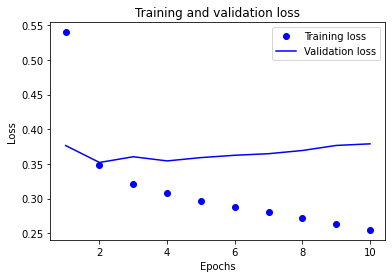

In [13]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

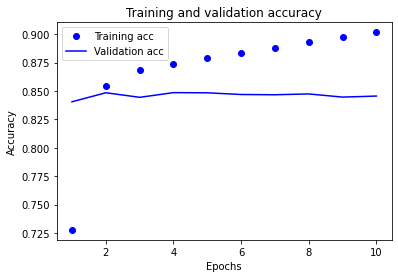

In [14]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 4. 학습된 Embedding 레이어 분석

In [15]:
embedding_layer = model_1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 16)


In [16]:
import os

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [17]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['지루']
vector

array([ 0.18022242,  0.28261063, -0.216854  ,  0.11110672,  0.08888896,
       -0.22014211, -0.18545398, -0.1524901 ,  0.15901783,  0.4181139 ,
       -0.15559661,  0.15551078,  0.21464992, -0.07638977,  0.11691546,
        0.24782524], dtype=float32)

In [18]:
word_vectors.similar_by_word("지루")

[('별로', 0.9796247482299805),
 ('유치', 0.9796197414398193),
 ('.??', 0.9676722288131714),
 ('실패', 0.9665553569793701),
 ('필름', 0.9634224772453308),
 ('모를까', 0.9632226824760437),
 ('지루함', 0.9627510905265808),
 ('-;', 0.9617817997932434),
 ('개밥', 0.9611238241195679),
 ('효', 0.959922730922699)]

### 2) Convolution Neural Network(1-D CNN)모델

In [19]:
vocab_size = 10000  
word_vector_dim = 16   

model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.MaxPooling1D(5))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.GlobalMaxPooling1D())
model_2.add(tf.keras.layers.Dense(8, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [20]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
198/198 [==============================] - 3s 7ms/step - loss: 0.5238 - accuracy: 0.7288 - val_loss: 0.3656 - val_accuracy: 0.8402
Epoch 2/10
198/198 [==============================] - 1s 5ms/step - loss: 0.3370 - accuracy: 0.8570 - val_loss: 0.3487 - val_accuracy: 0.8481
Epoch 3/10
198/198 [==============================] - 1s 5ms/step - loss: 0.2990 - accuracy: 0.8754 - val_loss: 0.3452 - val_accuracy: 0.8490
Epoch 4/10
198/198 [==============================] - 1s 5ms/step - loss: 0.2711 - accuracy: 0.8905 - val_loss: 0.3475 - val_accuracy: 0.8509
Epoch 5/10
198/198 [==============================] - 1s 5ms/step - loss: 0.2423 - accuracy: 0.9052 - val_loss: 0.3574 - val_accuracy: 0.8497
Epoch 6/10
198/198 [==============================] - 1s 5ms/step - loss: 0.2104 - accuracy: 0.9208 - val_loss: 0.3779 - val_accuracy: 0.8458
Epoch 7/10
198/198 [==============================] - 1s 5ms/step - loss: 0.1799 - accuracy: 0.9353 - val_loss: 0.4080 - val_accuracy: 0.8422
Epoch 

In [21]:
results = model_2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5291 - accuracy: 0.8310
[0.5290991067886353, 0.8310312032699585]


In [22]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


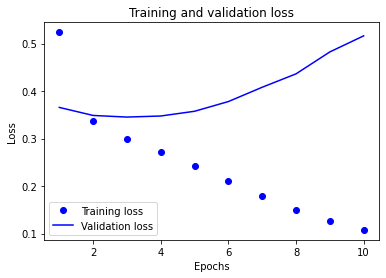

In [23]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

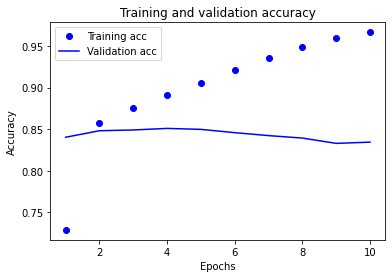

In [24]:
plt.clf()  

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 4. 학습된 Embedding 레이어 분석

In [25]:
embedding_layer = model_2.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 16)


In [26]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [27]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['지루']
vector

array([ 0.15324566, -0.13098714,  0.10458431,  0.15322952,  0.12449092,
       -0.01569067,  0.12061573, -0.09456939, -0.04858581,  0.03824122,
       -0.07549305,  0.02208417,  0.00646362,  0.14541739, -0.09010288,
       -0.02977668], dtype=float32)

In [28]:
word_vectors.similar_by_word("지루")

[('성적', 0.89200758934021),
 ('부리', 0.8892272114753723),
 ('철없', 0.8622621297836304),
 ('우월주의', 0.8583727478981018),
 ('바닥', 0.855747401714325),
 ('간신히', 0.8553895354270935),
 ('결핍', 0.8543521761894226),
 ('강도', 0.8535979390144348),
 ('광신도', 0.8494659662246704),
 ('썰렁', 0.8488237857818604)]

### 3) max pooling 모델

In [29]:
vocab_size = 10000 
word_vector_dim = 16

model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(tf.keras.layers.GlobalMaxPooling1D())
model_3.add(tf.keras.layers.Dense(8, activation='relu'))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history = model_3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
198/198 [==============================] - 1s 4ms/step - loss: 0.5963 - accuracy: 0.7630 - val_loss: 0.4528 - val_accuracy: 0.8171
Epoch 2/10
198/198 [==============================] - 1s 4ms/step - loss: 0.3930 - accuracy: 0.8354 - val_loss: 0.3686 - val_accuracy: 0.8378
Epoch 3/10
198/198 [==============================] - 1s 4ms/step - loss: 0.3338 - accuracy: 0.8602 - val_loss: 0.3532 - val_accuracy: 0.8457
Epoch 4/10
198/198 [==============================] - 1s 4ms/step - loss: 0.3023 - accuracy: 0.8754 - val_loss: 0.3510 - val_accuracy: 0.8467
Epoch 5/10
198/198 [==============================] - 1s 4ms/step - loss: 0.2791 - accuracy: 0.8869 - val_loss: 0.3539 - val_accuracy: 0.8468
Epoch 6/10
198/198 [==============================] - 1s 4ms/step - loss: 0.2598 - accuracy: 0.8955 - val_loss: 0.3608 - val_accuracy: 0.8459
Epoch 7/10
198/198 [==============================] - 1s 4ms/step - loss: 0.2433 - accuracy: 0.9034 - val_loss: 0.3701 - val_accuracy: 0.8454
Epoch 

In [31]:
results = model_3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4187 - accuracy: 0.8348
[0.41868147253990173, 0.8347539305686951]


In [32]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


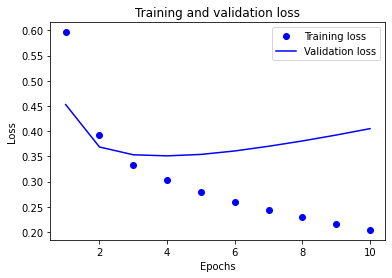

In [33]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

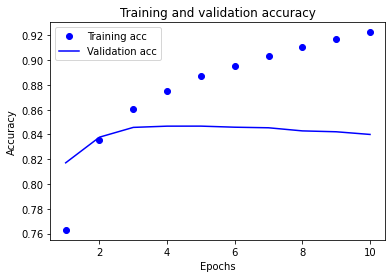

In [34]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 4. 학습된 Embedding 레이어 분석

In [35]:
embedding_layer = model_2.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 16)


In [36]:

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [37]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['지루']
vector

array([ 0.15324566, -0.13098714,  0.10458431,  0.15322952,  0.12449092,
       -0.01569067,  0.12061573, -0.09456939, -0.04858581,  0.03824122,
       -0.07549305,  0.02208417,  0.00646362,  0.14541739, -0.09010288,
       -0.02977668], dtype=float32)

In [38]:
word_vectors.similar_by_word("지루")

[('성적', 0.89200758934021),
 ('부리', 0.8892272114753723),
 ('철없', 0.8622621297836304),
 ('우월주의', 0.8583727478981018),
 ('바닥', 0.855747401714325),
 ('간신히', 0.8553895354270935),
 ('결핍', 0.8543521761894226),
 ('강도', 0.8535979390144348),
 ('광신도', 0.8494659662246704),
 ('썰렁', 0.8488237857818604)]

## 5. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [39]:
from gensim.models import KeyedVectors

word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model' 

In [40]:
word_vectors.save('vectors.kv')
reloaded_word_vectors = KeyedVectors.load('vectors.kv')


In [41]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
print(word_vectors.wv["지루"])

[ 0.04174887 -0.21894366 -1.441043   -0.65588135  0.5381777  -0.24932627
 -1.2721392  -0.9349011  -0.99750704  0.29246134  1.3961207  -0.42496732
 -0.8030965  -0.01296767  2.397268    1.4943933  -0.32043195 -0.37196487
  0.63323635  1.3366741  -2.4578457   1.6403297   2.098323    0.6416305
  1.0303649   1.0531819   0.5380543   1.3501654   1.9899552  -0.078539
 -0.13185968 -0.5480784  -1.8893849  -0.9229791   0.4664928   1.3092248
 -2.2880766   0.37046084  1.2550128  -0.05545815  0.23954934 -0.93439806
 -0.6775805   2.4420333  -0.55737174 -0.81948894 -0.06877042 -1.2745227
  1.7742481   0.8814029  -0.33158144 -0.518086   -0.7392571  -0.62477165
  0.5336477  -1.080377    1.4759496  -0.56383216  1.0778964  -0.1535129
  0.28932756  0.0729184   0.5195994  -1.480617   -0.6663279  -0.8334627
  0.9109524  -0.9392463  -0.40699846 -0.38619068  3.2585053  -0.18726757
 -0.19806731 -1.2285595  -2.0928824   0.0425626   0.45743722  0.3735978
  0.1352734  -0.9122646   0.689723    0.56783    -0.257061 

In [42]:
print(word_vectors.wv.most_similar("재미"))

[('묘미', 0.6163142919540405), ('취미', 0.6034970283508301), ('흥미', 0.5939850211143494), ('유머', 0.5888698101043701), ('보람', 0.5689517259597778), ('즐거움', 0.5631207823753357), ('개그', 0.5552946329116821), ('이야기', 0.5536993741989136), ('연애', 0.552293598651886), ('열의', 0.546456515789032)]


In [43]:
vocab_size = 10000    
word_vector_dim = 100
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

- 1. LSTM

In [44]:
from tensorflow.keras.initializers import Constant

#LSTM 모델 구성
model_4 = tf.keras.Sequential()
model_4.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))   
model_4.add(tf.keras.layers.LSTM(128))
model_4.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [45]:
# 학습의 진행
model_4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model_4.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
198/198 [==============================] - 4s 13ms/step - loss: 0.4858 - accuracy: 0.7616 - val_loss: 0.4162 - val_accuracy: 0.8119
Epoch 2/10
198/198 [==============================] - 2s 11ms/step - loss: 0.3666 - accuracy: 0.8362 - val_loss: 0.3489 - val_accuracy: 0.8461
Epoch 3/10
198/198 [==============================] - 2s 11ms/step - loss: 0.3148 - accuracy: 0.8637 - val_loss: 0.3313 - val_accuracy: 0.8552
Epoch 4/10
198/198 [==============================] - 2s 11ms/step - loss: 0.2789 - accuracy: 0.8826 - val_loss: 0.3261 - val_accuracy: 0.8583
Epoch 5/10
198/198 [==============================] - 2s 11ms/step - loss: 0.2531 - accuracy: 0.8962 - val_loss: 0.3255 - val_accuracy: 0.8618
Epoch 6/10
198/198 [==============================] - 2s 11ms/step - loss: 0.2257 - accuracy: 0.9093 - val_loss: 0.3375 - val_accuracy: 0.8578
Epoch 7/10
198/198 [==============================] - 2s 11ms/step - loss: 0.2039 - accuracy: 0.9189 - val_loss: 0.3415 - val_accuracy: 0.8601

In [46]:
results = model_4.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4398 - accuracy: 0.8531
[0.4397776126861572, 0.8531033396720886]


- Embedding

In [47]:
embedding_layer = model_4.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 100)


In [48]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_4.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [49]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.45958686, -1.601573  , -3.4878547 ,  1.454709  ,  0.23673673,
        1.639266  ,  0.08901233, -2.9346669 , -0.9054664 ,  1.2206489 ,
        0.40650648,  1.1962968 , -3.019989  , -0.11251885,  0.59873974,
        0.3061168 ,  1.2528764 ,  0.5936597 ,  2.073961  , -2.2969108 ,
        0.7798964 ,  1.6257489 ,  1.1709113 , -2.0648015 , -2.5925426 ,
       -0.38106653,  0.9447873 ,  0.5080243 ,  1.795718  , -1.1872504 ,
       -2.9187498 , -0.6708434 , -2.2165742 ,  1.6507351 , -0.32736728,
       -1.2981687 , -1.4701825 ,  1.0513557 , -2.3198268 ,  0.682717  ,
       -0.12583236,  0.90590364, -0.5238785 ,  4.008282  ,  1.1221327 ,
        0.49109992,  1.8677002 , -0.09359022,  2.4385908 , -2.6189897 ,
        0.80338866,  3.193386  ,  0.97337264, -0.5866932 , -0.9776467 ,
       -1.3814433 ,  1.0396596 , -0.6146893 ,  1.0162638 ,  1.1344126 ,
        2.8343618 , -0.83703756, -1.3972175 , -1.6713805 , -0.9871903 ,
        2.0700092 ,  0.03405891,  0.02439094, -1.2233745 , -0.92

In [50]:
word_vectors.similar_by_word("재미")

[('묘미', 0.6184396147727966),
 ('취미', 0.601413369178772),
 ('흥미', 0.5938342809677124),
 ('유머', 0.5822902321815491),
 ('보람', 0.5606368184089661),
 ('공감', 0.5517803430557251),
 ('개그', 0.5474673509597778),
 ('즐거움', 0.5472301244735718),
 ('연애', 0.54562908411026),
 ('이야기', 0.5362117290496826)]

- Convolution Neural Network(1-D CNN)

In [51]:
model_5 = tf.keras.Sequential()
model_5.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))
model_5.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_5.add(tf.keras.layers.MaxPooling1D(5))
model_5.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_5.add(tf.keras.layers.GlobalMaxPooling1D())
model_5.add(tf.keras.layers.Dense(8, activation='relu'))
model_5.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [52]:
model_5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history = model_5.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
198/198 [==============================] - 2s 7ms/step - loss: 0.6134 - accuracy: 0.6475 - val_loss: 0.5181 - val_accuracy: 0.7445
Epoch 2/10
198/198 [==============================] - 1s 6ms/step - loss: 0.4739 - accuracy: 0.7760 - val_loss: 0.4457 - val_accuracy: 0.7956
Epoch 3/10
198/198 [==============================] - 1s 6ms/step - loss: 0.4121 - accuracy: 0.8137 - val_loss: 0.4126 - val_accuracy: 0.8150
Epoch 4/10
198/198 [==============================] - 1s 6ms/step - loss: 0.3675 - accuracy: 0.8377 - val_loss: 0.3882 - val_accuracy: 0.8271
Epoch 5/10
198/198 [==============================] - 1s 6ms/step - loss: 0.3368 - accuracy: 0.8543 - val_loss: 0.3788 - val_accuracy: 0.8330
Epoch 6/10
198/198 [==============================] - 1s 6ms/step - loss: 0.3146 - accuracy: 0.8659 - val_loss: 0.3800 - val_accuracy: 0.8332
Epoch 7/10
198/198 [==============================] - 1s 6ms/step - loss: 0.2929 - accuracy: 0.8770 - val_loss: 0.3723 - val_accuracy: 0.8388
Epoch 

In [53]:
results = model_5.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3978 - accuracy: 0.8350
[0.3977825939655304, 0.8349980711936951]


- Embedding

In [54]:
embedding_layer = model_5.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 100)


In [55]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_5.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [56]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.4617663 , -1.3990711 , -3.3223274 ,  1.4396347 ,  0.16329455,
        1.5552385 ,  0.05046738, -2.5381346 , -1.1072984 ,  1.2693486 ,
        0.9654916 ,  0.8063761 , -3.1520877 ,  0.15037203,  0.67874026,
        0.4438124 ,  1.5075983 ,  0.80786914,  2.50622   , -2.6075916 ,
        0.7965966 ,  1.9871999 ,  1.3102884 , -1.882547  , -2.842563  ,
       -0.51336706,  1.1101793 ,  0.12842244,  1.8514721 , -1.2667698 ,
       -2.8324432 , -1.1315594 , -1.9900172 ,  1.2764349 , -0.3782124 ,
       -1.1942608 , -1.9431773 ,  1.0395497 , -2.0929723 ,  0.98212475,
       -0.05481824,  0.5398856 , -0.7447538 ,  3.7208648 ,  1.2084625 ,
        0.4607436 ,  1.6559074 , -0.13702649,  2.3683093 , -2.7270455 ,
        1.1321144 ,  2.6316276 ,  0.94724816, -0.92420864, -0.92097867,
       -1.477497  ,  1.0452442 , -0.85884523,  1.2103629 ,  1.4940842 ,
        2.520919  , -0.78357315, -1.6722168 , -1.4454374 , -0.99462956,
        1.494977  , -0.240971  ,  0.17329858, -1.3990008 , -0.85

In [57]:
word_vectors.similar_by_word("재미")

[('흥미', 0.5894554257392883),
 ('유머', 0.5884160399436951),
 ('취미', 0.5843777656555176),
 ('즐거움', 0.569054365158081),
 ('보람', 0.5675650835037231),
 ('개그', 0.5542932748794556),
 ('연애', 0.5506496429443359),
 ('이야기', 0.5425036549568176),
 ('묘미', 0.5418617725372314),
 ('감성', 0.5406346321105957)]

- 3) Global max pooling 모델

In [58]:
model_6 = tf.keras.Sequential()
model_6.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))   
model_6.add(tf.keras.layers.GlobalMaxPooling1D())
model_6.add(tf.keras.layers.Dense(8, activation='relu'))
model_6.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model_6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


In [59]:
# 학습의 진행
model_6.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history = model_6.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
198/198 [==============================] - 1s 5ms/step - loss: 0.7027 - accuracy: 0.5757 - val_loss: 0.6396 - val_accuracy: 0.6360
Epoch 2/10
198/198 [==============================] - 1s 4ms/step - loss: 0.6213 - accuracy: 0.6553 - val_loss: 0.6019 - val_accuracy: 0.6767
Epoch 3/10
198/198 [==============================] - 1s 4ms/step - loss: 0.5886 - accuracy: 0.6878 - val_loss: 0.5746 - val_accuracy: 0.7008
Epoch 4/10
198/198 [==============================] - 1s 4ms/step - loss: 0.5631 - accuracy: 0.7106 - val_loss: 0.5523 - val_accuracy: 0.7199
Epoch 5/10
198/198 [==============================] - 1s 4ms/step - loss: 0.5405 - accuracy: 0.7288 - val_loss: 0.5366 - val_accuracy: 0.7311
Epoch 6/10
198/198 [==============================] - 1s 4ms/step - loss: 0.5203 - accuracy: 0.7433 - val_loss: 0.5168 - val_accuracy: 0.7447
Epoch 7/10
198/198 [==============================] - 1s 4ms/step - loss: 0.5029 - accuracy: 0.7547 - val_loss: 0.5035 - val_accuracy: 0.7545
Epoch 

In [60]:
results = model_6.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4793 - accuracy: 0.7702
[0.47932443022727966, 0.7702056765556335]


- Embedding

In [61]:
embedding_layer = model_6.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 100)


In [62]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_6.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [63]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-4.4878754e-01, -1.4467459e+00, -3.2494924e+00,  1.2573234e+00,
        1.8947068e-01,  1.3727838e+00,  1.6719986e-01, -2.6990793e+00,
       -9.3271405e-01,  9.8711437e-01,  2.6287699e-01,  1.2217263e+00,
       -3.0392289e+00, -1.7037337e-01,  1.0140899e+00,  2.3719741e-01,
        1.2767925e+00,  6.4384866e-01,  2.2712181e+00, -2.3775148e+00,
        5.0424111e-01,  1.3037276e+00,  1.4887810e+00, -1.9011835e+00,
       -2.2861602e+00, -5.0139570e-01,  7.2444344e-01,  2.8450629e-01,
        1.5825648e+00, -1.1265730e+00, -2.8436053e+00, -7.2911263e-01,
       -2.2095640e+00,  1.8859230e+00, -2.8752780e-01, -1.2616376e+00,
       -1.2107424e+00,  8.8700169e-01, -2.1216857e+00,  8.5556918e-01,
       -7.7485077e-02,  8.7227386e-01, -5.3655195e-01,  4.0678658e+00,
        1.6169792e+00,  8.5914320e-01,  1.5715870e+00, -8.7751158e-02,
        2.3042886e+00, -2.6211133e+00,  7.8341722e-01,  3.2191529e+00,
        1.0066509e+00, -5.9529799e-01, -9.9486661e-01, -1.4266366e+00,
      

In [64]:
word_vectors.similar_by_word("재미")

[('묘미', 0.6152012944221497),
 ('취미', 0.597612738609314),
 ('흥미', 0.588805615901947),
 ('유머', 0.5813016891479492),
 ('보람', 0.5715156197547913),
 ('이야기', 0.5625768899917603),
 ('즐거움', 0.552841067314148),
 ('개그', 0.5514690279960632),
 ('재주', 0.5455477833747864),
 ('연애', 0.5446282029151917)]

#### 리뷰 예측 해보기

In [65]:
Tokenizer = Mecab()

def sentiment_predict(new_sentence):
    new_sentence = tokenizer.morphs(new_sentence) # 토큰화
    new_sentence.insert(0, '<BOS>')
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    new_sentence = wordlist_to_indexlist(new_sentence) # encoding
    new_sentence = [new_sentence]

    new_sentence = tf.keras.preprocessing.sequence.pad_sequences(new_sentence,
                                                    value=word_to_index["<PAD>"],
                                                    padding='pre',
                                                    maxlen=maxlen)
    
    score = float(model_4.predict(new_sentence)) # 예측
    
    if score > 0.5:
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [66]:
def scores():
    text_arr = [
    '이건 신의 걸작이다 정말 재밌음.',
    '배우분들 연기는 좋아요~소재가 신박해서 봤는데 처음엔 픽픽 웃으며 재밌었으나 중반부턴 루즈한 감이,,,ㅠㅠㅠ',
    '시간아까워서 중간에나옴',
    '90년대식 전라도식 꼴통 무비 개핵노잼ㅜ',
    '어줍짢은 마블 영화보다 훨씬 재밌었음',
    '저예산 영화임에도 주인공들 연기가 넘 자연스럽고 음향.효과가 영화분위기 압도...사람과 사회에 대해 생각을 많이 하게 하는 작품이었습니다.',
    '일상생활에 있는 스토리로 스릴러를 만들어서 그런지 이입이 더 잘되었으며 오랜만에 긴장하면서 영화 본것같다.'
    ]
    
    for i in text_arr:
        print(i)
        score = sentiment_predict(i)
        print(score)
    
scores()

이건 신의 걸작이다 정말 재밌음.
99.74% 확률로 긍정 리뷰입니다.

None
배우분들 연기는 좋아요~소재가 신박해서 봤는데 처음엔 픽픽 웃으며 재밌었으나 중반부턴 루즈한 감이,,,ㅠㅠㅠ
83.29% 확률로 긍정 리뷰입니다.

None
시간아까워서 중간에나옴
99.99% 확률로 부정 리뷰입니다.

None
90년대식 전라도식 꼴통 무비 개핵노잼ㅜ
99.77% 확률로 부정 리뷰입니다.

None
어줍짢은 마블 영화보다 훨씬 재밌었음
95.84% 확률로 긍정 리뷰입니다.

None
저예산 영화임에도 주인공들 연기가 넘 자연스럽고 음향.효과가 영화분위기 압도...사람과 사회에 대해 생각을 많이 하게 하는 작품이었습니다.
99.69% 확률로 긍정 리뷰입니다.

None
일상생활에 있는 스토리로 스릴러를 만들어서 그런지 이입이 더 잘되었으며 오랜만에 긴장하면서 영화 본것같다.
99.96% 확률로 긍정 리뷰입니다.

None


## 회고

- 어려웠던 점 : 한국어 Word2Vec 임베딩 활용하여 성능 개선을 했을때 처음 설정하는 법이 어려웠다.
- 알아낸 점 및 모호한 점 : 사전에 학습된 한국어 embedding 한 결과가 '재미' 라는 단어에 더 유사성이 있는 결과가 나왔다. 결과적으로 한국어 Word2Vec을 하기 전에는 정확도가 85%가 넘지 않았는데, 하고나서 LSTM만 정확도가 85%을 넘었다.
- 노력한 점 : epoch에 따라 정확도가 달라져서 최대한 정확도를 높게 받을 수 있도록 찾아봤다. 
- 자기다짐 : 주로 리뷰 긍정, 부정 예측하는데 있어서 토큰화를 하는 과정을 자세히 알아야 겠다. model의 shape을 설정하는 것을 조금 더 공부해야겠다.